<a href="https://colab.research.google.com/github/KepryDeSousa/Inteligencia-Computacional-I/blob/main/Relatorio_VI__MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Relatorio V: *Redes Multicamadas*
> Aluno : Jarom Kepri de Sousa M.
>
> Curso: Engenharia de Energias

Desafio:
> Implemente um sistema de controle para o motor CC com função de transferência da equação 18 do material anexo.
>
>através da estimação da função de transferência inversa da planta utilizando uma rede MLP.
>
>Defina os hiperparâmatros da rede, por tentativa e erro, deixando expresso quais o limites inferiores e superiores da faixa de variação escolhida pra essa busca, assim como o número de medições anteriores necessárias para se obter um bom resultado de modelagem.

 



In [ ]:
!pip install tensorflow

Epoch 1/30
25/25 [==============================] - 1s 5ms/step - loss: 23.5981 - val_loss: 12.2653
Epoch 2/30
25/25 [==============================] - 0s 2ms/step - loss: 10.5999 - val_loss: 9.8503
Epoch 3/30
25/25 [==============================] - 0s 2ms/step - loss: 9.3152 - val_loss: 9.6470
Epoch 4/30
25/25 [==============================] - 0s 3ms/step - loss: 8.7550 - val_loss: 8.5454
Epoch 5/30
25/25 [==============================] - 0s 2ms/step - loss: 7.4674 - val_loss: 6.6538
Epoch 6/30
25/25 [==============================] - 0s 2ms/step - loss: 5.1617 - val_loss: 3.8241
Epoch 7/30
25/25 [==============================] - 0s 3ms/step - loss: 2.5043 - val_loss: 1.3933
Epoch 8/30
25/25 [==============================] - 0s 2ms/step - loss: 0.8464 - val_loss: 0.4632
Epoch 9/30
25/25 [==============================] - 0s 3ms/step - loss: 0.3876 - val_loss: 0.3040
Epoch 10/30
25/25 [==============================] - 0s 2ms/step - loss: 0.3208 - val_loss: 0.2764
Epoch 11/30
25/2

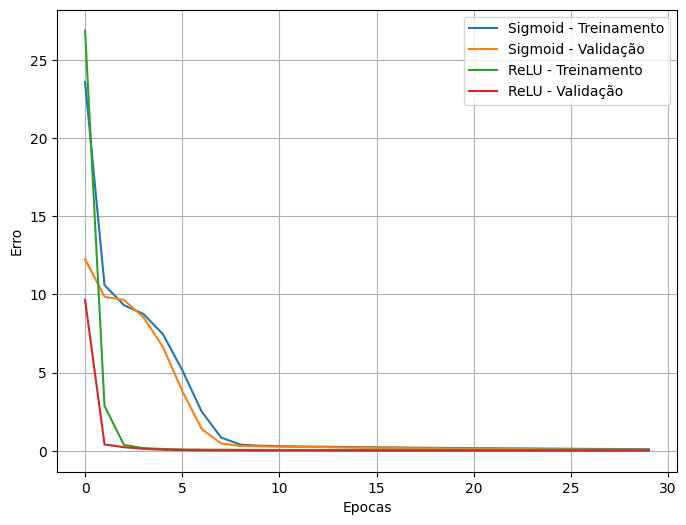

In [22]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Dados dos parâmetros do motor CC
vi_max = 30.0  # Volts
Ia_max = 2.0  # Amperes
Ra = 3.0  # Ohms
La = 6.0e-3  # Henries
Ki = 50.0e-3  # Nm/A
T_nominal = 0.1  # Newton-metro
Jm = 40.0e-6  # Kg*m^2
Bm = 40.0e-6  # Kg*m^2/s
w_nominal = 300.0  # Radianos/s

def planta(vi):
    Kp = Ki / (Ra * La)
    num = [Kp]
    den = [La * Jm, (La * Bm + Ra * Jm), (Ra * Bm + Kp ** 2)]
    _, a, _ = signal.lsim((num, den), vi, np.linspace(0, len(vi), len(vi)))
    return a

#   Banco
np.random.seed(0)
N = 1000
vi = np.random.uniform(0, vi_max, N)
torque = planta(vi)

#
X_train, X_test, y_train, y_test = train_test_split(vi, torque, test_size=0.2, random_state=0)

# Pré-processament Sigmoid
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))

# Sigmoid
model_sigmoid = Sequential()
model_sigmoid.add(Dense(15, activation='sigmoid', input_shape=(1,)))
model_sigmoid.add(Dense(15, activation='sigmoid'))
model_sigmoid.add(Dense(1))

# ReLU
model_relu = Sequential()
model_relu.add(Dense(15, activation='relu', input_shape=(1,)))
model_relu.add(Dense(15, activation='relu'))
model_relu.add(Dense(1))

# modelos
model_sigmoid.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())
model_relu.compile(optimizer=Adam(learning_rate=0.01), loss=MeanSquaredError())


history_sigmoid = model_sigmoid.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)
history_relu = model_relu.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1)

# Plot do gráfico de treinamento
plt.figure(figsize=(8, 6))
plt.plot(history_sigmoid.history['loss'], label='Sigmoid - Treinamento')
plt.plot(history_sigmoid.history['val_loss'], label='Sigmoid - Validação ')
plt.plot(history_relu.history['loss'], label='ReLU - Treinamento ')
plt.plot(history_relu.history['val_loss'], label='ReLU - Validação')
plt.xlabel('Epocas')
plt.ylabel('Erro')
plt.legend()
plt.grid(True)
plt.show()



temos o erro no treinamento, e a validação de que o erro está baixando ao passar das epocas.

In [16]:
import pandas as pd

  #  RPM - Sigmoid
velocidade_angular_rad_s_sigmoid = model_sigmoid.predict(X_test)  # Obter a velocidade angular em rad/s
RPM_sigmoid = velocidade_angular_rad_s_sigmoid * (60 / (2 * np.pi))  # Converter para RPM
RPM_sigmoid = pd.DataFrame(RPM_sigmoid)
# RPM -  ReLU
velocidade_angular_rad_s_relu = model_relu.predict(X_test)  # Obter a velocidade angular em rad/s
RPM_relu = velocidade_angular_rad_s_relu * (60 / (2 * np.pi))  # Converter para RPM
RPM_relu = pd.DataFrame(RPM_relu)

print(f"Sigmoid Min - max: {RPM_sigmoid.values.min()} - {RPM_sigmoid.values.max()}")
print(f"Relu Min - max: {RPM_relu.values.min()} - {RPM_relu.values.max()}")


7/7 [==============================] - 0s 1ms/step
Sigmoid Min - max: 1.6144710779190063 - 99.78478240966797
Relu Min - max: 1.9516363143920898 - 101.38530731201172


## Referencias:  
> https://www.citisystems.com.br/motor-cc/
>
>https://iaexpert.academy/2018/05/17/deep-learning-redes-neurais-com-keras-e-python/
>
